In [1]:
import re
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def average_line(lines):
    """
    Takes a list of lines, each line: [slope, intercept] \n
    Returns: average slope and intercept
    """
    cnt, slope, intercept = 0,0,0
    for line in lines:
        if line:
            slope += line[0]
            intercept += line[1]
            cnt+=1
    return None if cnt==0 else (slope/cnt, intercept/cnt)

def get_x(y, line):
    # calculates x coord for a given y coord
    slope, intercept = line
    return int((y - intercept) / slope)

def intersects_with_line(y,line):
    yd,yu = (line[1],line[3]) if line[1]<line[3] else (line[1],line[3])
    return yd<=y<=yu


def hough_lines(img, ρ, θ, α, min_line_len, max_line_gap,debug=False):
    """
    `img` should be the output of a Canny transform.\n
    Returns an image with lanes drawn.
    """
    lines = cv2.HoughLinesP(img, ρ, θ, α, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img,pot_lines = draw_lanes(line_img, lines,debug=debug)
    for index,line in enumerate(pot_lines):
        if line:
            cv2.line(line_img, (get_x(img.shape[0], line), img.shape[0]), (get_x(0, line), 0), 
            (0,0,255) if index == 0 else (0,255,0), 3)  
    return line_img,pot_lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_current_side(dashed_line):
    # Return True if is left lane
    return DIM[0]//2 < get_x(DIM[1]-120,dashed_line) 

def get_line_params(line):
    x1,y1,x2,y2 = line
    if x1 == x2:
        return 100,100 # to remove strait lines 
    return (y2-y1)/(x2-x1),(x1*y2-x2*y1)/(x1-x2)

def plotz(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()
    
def line_intersection_with_border(line,width,height,debug=False):
    xy = []
    for border in [(0,1,0),(0,1,-height),(1,0,0),(1,0,-width)]:
        x = (1*border[2] - border[1]*-line[1])    //  (-line[0]*border[1]-border[0]*1)
        y = (border[0]*-line[1] + line[0]*border[2])//(-line[0]*border[1]-border[0]*1)
        if 0<=x<=width and 0<=y<=height:
            xy.append((x,y)) 
    return xy

def calc_angle(current,target):
    x1,y1,x2,y2 = current
    a1,b1,c1 = y2-y1,x2-x1,x1*y2-x2*y1
    x1,y1,x2,y2 = target
    a2,b2,c2 = y2-y1,x2-x1,x1*y2-x2*y1
    return np.arctan2(a2*b1-a1*b2,a1*a2+b1*b2)*(180/np.pi)
    
def top_down_view(image,lines,lane=1):
    # zakrepeno malku
    off_l = 0.0
    off_r = 1 - off_l
    o = 0
    # grab the image shape
    width = image.shape[1]
    height = image.shape[0]
    if lane == 'left':
        left_lane = lines[1]
        right_lane = lines[0]
    elif lane == 'right':
        left_lane = lines[0]
        right_lane = lines[2]
    else:
        left_lane = lines[1]
        right_lane = lines[2]
    src  = np.float32([ line_intersection_with_border(left_lane,width,height)[0], 
                        line_intersection_with_border(right_lane,width,height)[0],
                        line_intersection_with_border(right_lane,width,height)[1], 
                        line_intersection_with_border(left_lane,width,height)[1]])
    src = np.reshape(src, (4,1,2))
    # destination points are corners of output image
    dst = np.float32([[o,width * off_l], [height-o,width * off_l], [height-o,width * off_r], [o,width * off_r]])
    dst = np.reshape(dst, (4,1,2))
    # given src and dst points, calculate the perspective transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, (height, width))

    # Return the resulting image and matrix
    return warped, M, Minv
    
def draw_car_and_target_direction(image,lines,lane,color=[0,255,255],thickness=2):
    img = np.copy(image)
    width = image.shape[1]
    height = image.shape[0]
    if lane == 'left':
        left_lane = lines[1]
        right_lane = lines[0]
    elif lane == 'right':
        left_lane = lines[0]
        right_lane = lines[2]

    src  = np.array([ line_intersection_with_border(left_lane,width,height)[0], 
                        line_intersection_with_border(right_lane,width,height)[0],
                        line_intersection_with_border(right_lane,width,height)[1], 
                        line_intersection_with_border(left_lane,width,height)[1]])
    current_line =  [width//2, 0, width//2, height]
    target_line = [int((src[0][0]+src[1][0])//2), 0, int((src[2][0]+src[3][0])//2), height]

    
    cv2.line(img,(current_line[0], current_line[1]), (current_line[2], current_line[3]), color, thickness)
    cv2.line(img,(target_line[0], target_line[1]), (target_line[2], target_line[3]), color, thickness)
    return img,current_line,target_line

In [3]:
def grouper(iterable,treshold = 30):
    prev = None
    group = []
    for slope,intersection,line,x_iter in iterable:
        if prev is None or x_iter - prev <= treshold:# moze da se dodae i flterce da se ostranat dalecni slopes
            group.append((slope,intersection,line))
        else:
            yield group
            group = [(slope,intersection,line)]
        prev = x_iter
    if group:
        yield group
           
def draw_lanes(image, lines, color=[0, 255, 0], thickness=3, past = 5, debug=False):

    img = np.copy(image)
    # points for lines
    ysize = img.shape[0]
    xsize = 600
    if lines is None:
        return img,[None,None,None]
 
    lines_params = np.empty((0, 4))
    for i,line in enumerate(lines):
        slope,intersection = get_line_params(line[0])
        if strait_slope_range[0] < abs(slope) < strait_slope_range[1]:
            x_iter = get_x(ysize-50, (slope, intersection))
            #lines_params.append([slope,intersection,line[0],x_iter])
            lines_params = np.append(lines_params, [[slope,intersection,line[0],x_iter]], axis=0)
    if lines_params.shape[0] == 0:
        return img,[None,None,None]
    #lines_params  = np.array(lines_params)  
    sorted_lines_params = lines_params[lines_params[:, 3].argsort()]
 
    grouped_lines = []
    grouped_lines_points = []
    for grouped_line in grouper(sorted_lines_params):
        grouped_lines.append(average_line(grouped_line))
        grouped_lines_points.append([list(line[2]) for line in grouped_line])
        
    if len(past_potental_lanes[0]) == past:
    
        dif_dash,dif_left,dif_right = (0,xsize),(0,xsize),(0,xsize)
        pot_dash,pot_left,pot_right = [None]*3
        past_dash,past_left,past_right = [average_line(past_potental_lanes[0]),average_line(past_potental_lanes[1]),average_line(past_potental_lanes[2])]
        x_grouped_lines = [get_x(ysize//2, grouped_line) for grouped_line in grouped_lines]
        
        for ind,x_grouped_line in enumerate(x_grouped_lines):
            if past_dash and dif_dash[1] > abs(x_grouped_line - get_x(ysize//2, past_dash)):
                dif_dash = (ind, abs(x_grouped_line - get_x(ysize//2, past_dash))) 
            if past_left and dif_left[1] > abs(x_grouped_line - get_x(ysize//2, past_left)):
                dif_left = (ind, abs(x_grouped_line - get_x(ysize//2, past_left))) 
            if past_right and dif_right[1] > abs(x_grouped_line - get_x(ysize//2, past_right)):
                dif_right = (ind, abs(x_grouped_line - get_x(ysize//2, past_right))) 

        pot_dash = grouped_lines[dif_dash[0]] if dif_dash[1] < 40 else None # ke nemae ako nema bliska za 40 px ili nema past dash
        pot_left = grouped_lines[dif_left[0]] if dif_left[1] < 40  else None #ako se stavi noone ke pocne druga da bara
        pot_right = grouped_lines[dif_right[0]] if dif_right[1] < 40 else None
       
        is_dased_line = dash_lane_test(grouped_lines_points[grouped_lines.index(pot_dash)]) if pot_dash else False
        
        if not past_dash and not pot_dash: #ako nemame dashed nikakva baraj nova niz site linii
            is_dahed_lines = [dash_lane_test(grouped_lines_point) for grouped_lines_point in grouped_lines_points]
            pot_dash = grouped_lines.pop(is_dahed_lines.index(True)) if True in is_dahed_lines else None
            is_dased_line = True

        if not pot_left and (past_dash or pot_dash): # potencijalna ke imame ako  nema bliska iako ima past lines poarno e bidejki inaku treba da cekame da se ostranat
            x_dashed_line = get_x(ysize//2, pot_dash if pot_dash else past_dash)
            x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
            left_line_diff = xsize
            past_x_left_diff = sum([left_diff for left_diff in past_lane_dff[0] if left_diff])
            past_x_left_diff = -40 if past_x_left_diff == 0 else past_x_left_diff/len([left_diff for left_diff in past_lane_dff[0] if left_diff])
            for x_diff in x_grouped_lines_diff:
                if x_diff < -past_x_left_diff + 50 and abs(left_line_diff) > abs(x_diff):
                    left_line_diff = x_diff
            if left_line_diff != xsize:        
                pot_left  = grouped_lines.pop(x_grouped_lines_diff.index(left_line_diff))
        
        if not pot_right and (past_dash or pot_dash):
            x_dashed_line = get_x(ysize//2, pot_dash if pot_dash else past_dash)
            x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
            right_line_diff = xsize
            past_x_right_diff = sum([right_diff for right_diff in past_lane_dff[0] if right_diff])
            past_x_right_diff = 40 if past_x_right_diff == 0 else past_x_right_diff/len([right_diff for right_diff in past_lane_dff[0] if right_diff])
            for x_diff in x_grouped_lines_diff:
                if x_diff > past_x_right_diff - 50 and right_line_diff > x_diff:
                    right_line_diff = x_diff 
            if right_line_diff != xsize:        
                pot_right  = grouped_lines.pop(x_grouped_lines_diff.index(right_line_diff))
        #final check
        if pot_dash == None  and past_dash == None:
            is_dased_line = False
            is_left_line = is_right_lane =  (get_x(ysize//2, pot_left) < get_x(ysize//2, pot_right)) if pot_left and pot_right else False
            past_lane_dff[0].append(None)
            past_lane_dff[1].append(None)
        else:
            is_left_line = get_x(ysize//2, pot_left)<get_x(ysize//2, pot_dash if pot_dash else past_dash) if pot_left else False
            is_right_lane = get_x(ysize//2, pot_dash if pot_dash else past_dash)<get_x(ysize//2,pot_right) if pot_right else False
            # temporal lines
            left_line_diff =  get_x(ysize//2, pot_dash if pot_dash else past_dash)- get_x(ysize//2, pot_left) if pot_left else None
            right_line_diff = get_x(ysize//2, pot_right) - get_x(ysize//2, pot_dash if pot_dash else past_dash) if pot_right else None
            past_lane_dff[0].append(left_line_diff if is_left_line else None)
            past_lane_dff[1].append(right_line_diff if right_line_diff else None)
       
        past_potental_lanes[0].append(pot_dash  if is_dased_line else None)
        past_potental_lanes[1].append(pot_left  if is_left_line  else None)
        past_potental_lanes[2].append(pot_right if is_right_lane else None)
        
        if len(past_potental_lanes[0]) > past:
            past_potental_lanes[0].pop(0)
            past_potental_lanes[1].pop(0)
            past_potental_lanes[2].pop(0)
            past_lane_dff[0].pop(0)
            past_lane_dff[1].pop(0) 
        potental_lines = [pot_dash  if pot_dash else None ,pot_left  if pot_left else None,pot_right  if pot_right else None]
    else:
        # find dashed line if not return nothing
        is_dahed_lines =  [dash_lane_test(grouped_lines_point) for grouped_lines_point in grouped_lines_points]
        if True not in is_dahed_lines:
            if debug:
                for group_line in grouped_lines:
                    cv2.line(img, (get_x(ysize, group_line), ysize), (get_x(0, group_line), 0), (255,0,0), thickness)  
                for line in lines:
                    cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), 
                    [255,255,0] if strait_slope_range[0] < abs(get_line_params(line[0])[0]) < strait_slope_range[1] else [255,0,255], 2) 
            return img,[None]*3
        dashed_line = grouped_lines.pop(is_dahed_lines.index(True))
        x_dashed_line = get_x(ysize//2, dashed_line)
        x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
        # find left and right line
        left_line_diff,right_line_diff = xsize,xsize
        left_line,right_line = None,None
        for x_diff in x_grouped_lines_diff:
            if x_diff < 0 and abs(left_line_diff) > abs(x_diff):
                left_line_diff = x_diff
            elif x_diff > 0 and right_line_diff > x_diff:
                right_line_diff = x_diff 
        if left_line_diff != xsize:        
            left_line  = grouped_lines.pop(x_grouped_lines_diff.index(left_line_diff))
            x_grouped_lines_diff.pop(x_grouped_lines_diff.index(left_line_diff))
        if right_line_diff != xsize:   
            right_line = grouped_lines.pop(x_grouped_lines_diff.index(right_line_diff))
            x_grouped_lines_diff.pop(x_grouped_lines_diff.index(right_line_diff))    
        # temporal lines append prev for the begining
        past_lane_dff[0].append(-left_line_diff if left_line else None)
        past_lane_dff[1].append(right_line_diff if right_line else None)
        past_potental_lanes[0].append(dashed_line if dashed_line else past_potental_lanes[0][-1])
        past_potental_lanes[1].append(left_line if left_line else (past_potental_lanes[1][-1] if past_potental_lanes[1]  else None))
        past_potental_lanes[2].append(right_line if right_line else (past_potental_lanes[2][-1] if past_potental_lanes[2] else None))
        if len(past_potental_lanes[0]) > past:
            past_potental_lanes[0].pop(0)
            past_potental_lanes[1].pop(0)
            past_potental_lanes[2].pop(0)
            past_lane_dff[0].pop(0)
            past_lane_dff[1].pop(0)       
        potental_lines = [average_line(past_potental_lanes[0]),average_line(past_potental_lanes[1]),average_line(past_potental_lanes[2])]   
    if debug:
        for group_line in grouped_lines:
            cv2.line(img, (get_x(ysize, group_line), ysize), (get_x(0, group_line), 0), (255,0,0), thickness)  
        for line in lines:
            cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), 
            [255,255,0] if strait_slope_range[0] < abs(get_line_params(line[0])[0]) < strait_slope_range[1] else [255,0,255], 2) 
    return img,potental_lines

In [4]:
def dash_lane_test(lines, step=5, threshold=2, transition=3, debug=False):
    colors = []
    line_filter = 0
    lezi = len([1 for line in lines if intersects_with_line(308-125,line)]) > 0
    for y_test in range(DIM[1]-120-step,step,-step):
        intercepted = [1 for line in lines if intersects_with_line(y_test,line)]
        if (len(intercepted)>0) == lezi:
            line_filter+=1
            if line_filter >= threshold:
                lezi = not lezi
                line_filter = 0
                colors.append((y_test,len(intercepted)))  
    if debug: print(colors)
    return len(colors) >= transition

In [5]:
# calibration params for sparkfun bot
DIM=(410, 308)
K=np.array([[171.0979583888746, 0.0, 203.832157593343], [0.0, 169.87861660728842, 152.47239113949564], [0.0, 0.0, 1.0]])
D=np.array([[-0.008369503627831692], [-0.07768839820625655], [0.10177033308737245], [-0.04056049534190911]])

In [6]:
# calibration params for duckietown bot
DIM=(408, 308)
K=np.array([[200.45528254856666, 0.0, 193.58838229266124], [0.0, 204.98105125775646, 136.8997130353786], [0.0, 0.0, 1.0]])
D=np.array([[-0.051386452545095], [0.18476371756060023], [-0.5729487022183332], [0.49089690391610674]])

### Process a single image

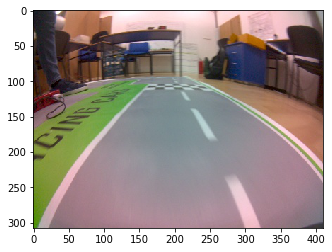

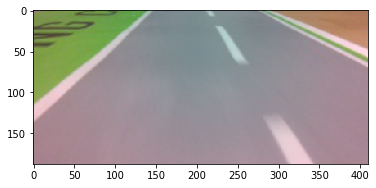

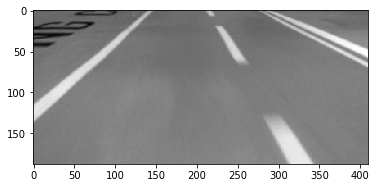

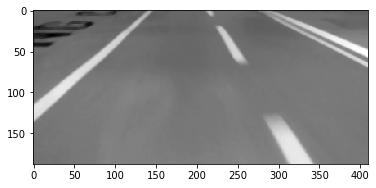

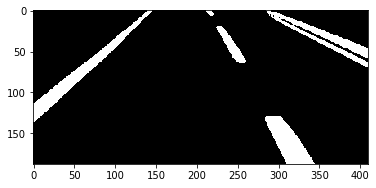

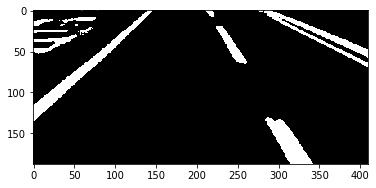

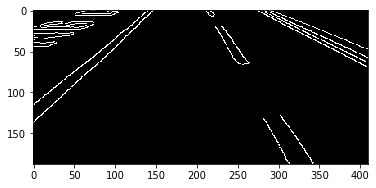

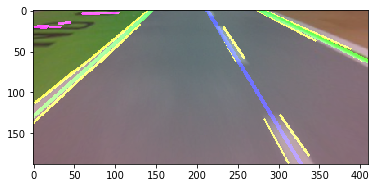

[(1.6352298850574711, -348.67005747126433), (-0.8849143227517313, 128.86418401911416), (0.4750751609030789, -132.3873329422815)]


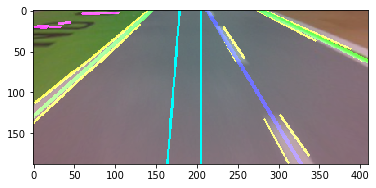

4.561807987457006


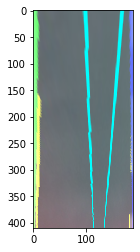

In [6]:
# applying pipeline to test images and saving them
past_potental_lanes = [[],[],[]]  
past_lane_dff = [[],[]] 
strait_slope_range = (0.2,3) 
im_path = r'Captures\sparkfun2'
im_name = '45.jpg'

# read raw image
test_img = mpimg.imread(f"{im_path}/{im_name}")
plotz(test_img)

# apply calibration
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[120:,:]
plotz(undistorted_img)

# convert to grayscale
gray_img = grayscale(undistorted_img)
plotz(gray_img)

# apply blur
blurred_img = cv2.medianBlur(gray_img,5)
plotz(blurred_img)

# treshold testing
ret,th1 = cv2.threshold(blurred_img,160,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(blurred_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,55,-6)
plotz(th1)
plotz(th2)

# canny image
t = 50
canny_img = canny(gray_img, t, t*2)
plotz(canny_img)

# calculate potential lines
lines_canny_img,pot_lanes = hough_lines(canny_img, 3, np.pi/180, 100, 10, 5,debug=True)#50 so 100
plotz(weighted_img(lines_canny_img, undistorted_img))
print(pot_lanes)

# get final image
final_img,current_line,target_line = draw_car_and_target_direction(
        weighted_img(lines_canny_img, undistorted_img),pot_lanes,'left')
plotz(final_img)
print(calc_angle(current_line,target_line))

# top down view 
top_down_img,M,Minv = top_down_view(final_img,pot_lanes,'left')
plotz(top_down_img)

### Iterate trough images

In [16]:
past_potental_lanes = [[],[],[]]  
past_lane_dff = [[],[]]  
strait_slope_range = (0.2,3)
im_path = r'Captures\sparkfun2'
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
for i in range(0,200):
    test_img = mpimg.imread(im_path+ str(i)+'.jpg')
    e1 = cv2.getTickCount()
    undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[120:,:]
    gray_img = grayscale(undistorted_img)
    blurred_img = gaussian_blur(gray_img, 5)
    #_,th1 = cv2.threshold(blurred_img,170,255,cv2.THRESH_BINARY)
    thresh1 = cv2.adaptiveThreshold(blurred_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,55,-6)
    t = 60
    canny_img = canny(thresh1, t, t*2)
    #print(i,end=' ')
    #print( [average_line(past_potental_lanes[0]),average_line(past_potental_lanes[1]),average_line(past_potental_lanes[2])]   )

    lines_canny_img,pot_lines = hough_lines(canny_img, 3, np.pi/180, 50, 10, 5,debug=True)#50 so 100
    #print((cv2.getTickCount() - e1)/cv2.getTickFrequency()*1000)     
    if pot_lines[0] and pot_lines[1]:
        final_img,current_line,target_line = draw_car_and_target_direction(weighted_img(lines_canny_img, undistorted_img),pot_lines,'left')
    else:
        final_img = undistorted_img
   
    #topdown,M,Minv = top_down_view(undistorted_img,pot_lines,'left')
    plt.imsave(im_path+'out/'+str(i)+'.jpg', final_img)

### Turn saved images to video

In [15]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

img_array = []
file_path = r'Captures\sparkfun2\out\'
for i in sorted_alphanumeric(os.listdir(file_path)):
    img = cv2.imread(file_path+i)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('run1.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()